<a href="https://colab.research.google.com/github/Blerk8/Dog-Breed-Identification/blob/master/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-class Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub

## 1. Problem

Identifying the breed of a dog given an image of a dog.

For example, in practice, if you have a photo of a dog, we want to be able to identify the breed. 

## 2. Data

The data we're using is from the Kaggle Dog Breed competition.
https://www.kaggle.com/c/dog-breed-identification/data 

## 3. Evaluation

Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed probability.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructed data) and therefore, we'll be using deep/transfer learning.
* There are 120 breeds of dogs and therefore, 120 different classes (multiclass).
* There are 10,000+ images in the training set, with labels.
* There are 10,000+ images in the test set, without labels. 

In [0]:
# Unzip the compressed folders
# !unzip "drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision/"

### Get our workspace ready

* Import TensorFlow 2.x 
* Import TensorFlow Hub
* Ensure that you're using a GPU

In [0]:
# Get Google drive mounted
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# Import TensorFlow and check version
# import tensorflow as tf
# print("TF version:", tf.__version__ )

In [0]:
# Import TensorFlow 2.x
try:
  # %tensorflow_version only works in Colab
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
# Import necessary tools and check versions
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__ )
print("TF Hub version:", hub.__version__ )

# Check GPU availability
print("GPU", "available (YES!!!)" if tf.config.list_physical_devices else "not available (NOO!!!)")

TF version: 2.1.0
TF Hub version: 0.7.0
GPU available (YES!!!)


## Get our data ready 

With all machine learning models, our data has to be in numerical format. So now we need to turn our images into numerical respresentations (tensors).

In [0]:
# Import pandas and describe the labels
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     a8da1804e683a16557ef4dc51b281399  scottish_deerhound
freq                                   1                 126


In [0]:
# View the data
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [0]:
# How many breeds are there?
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
golden_retriever         67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

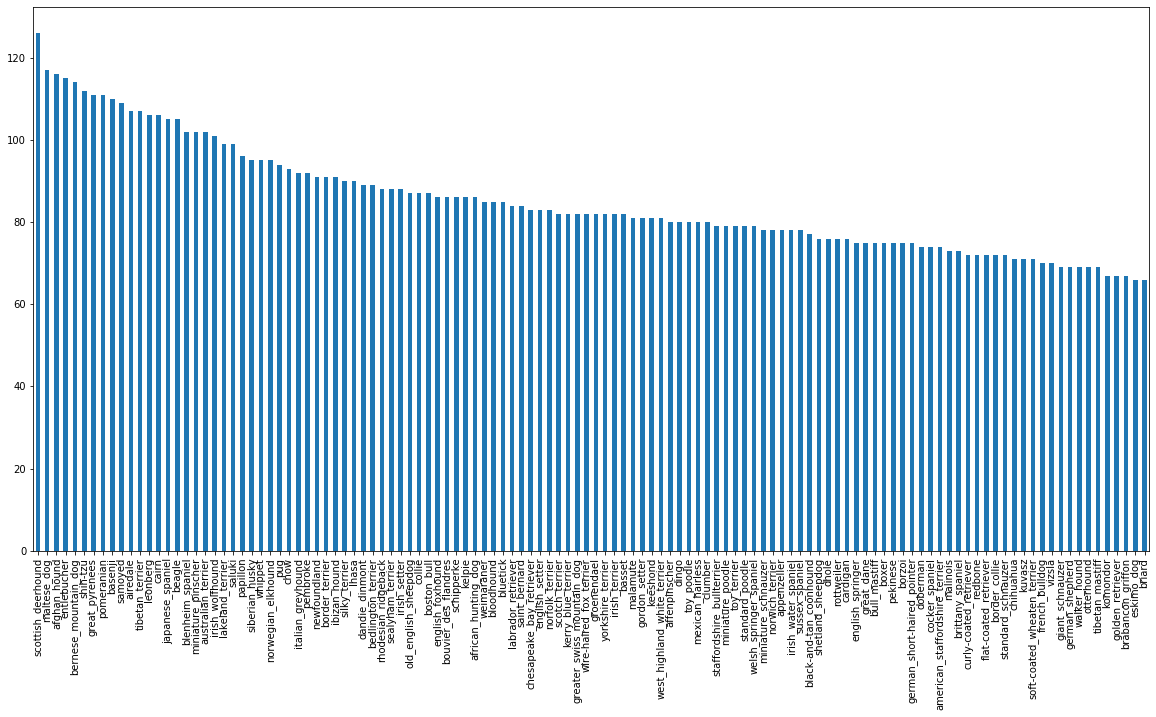

In [0]:
# Visualize the different breeds
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [0]:
# What is the middle-value and average of the counts of breeds?
labels_csv["breed"].value_counts().mean(), labels_csv["breed"].value_counts().median()

(85.18333333333334, 82.0)

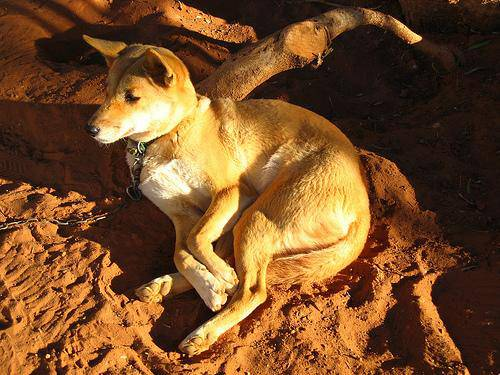

In [0]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all our image file pathnames.

In [0]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [0]:
# Check whether the number of filenames matches the number of images in the file
import os
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames and number of files match, proceed!")
else:
  print("Filenames and number of files do not match, check the file directory")

Filenames and number of files match, proceed!


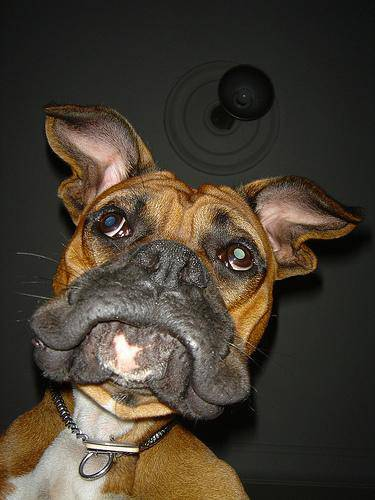

In [0]:
# One more check
Image(filenames[2808])

Now that we've got our training image filepaths in a list, let's prepare our labels

In [0]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # does the same as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [0]:
# See if the number of labels and filenames matches
if len(labels) == len(filenames):
  print("Labels and filenames match, proceed!")
else:
  print("Labels and filenames do not match, check labels and filenames")

Labels and filenames match, proceed!


In [0]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [0]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [0]:
# Example: Turing a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # should be 1 where the label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation sets

Since the data from Kaggel doesn't come with a validation set, we're going to create our own.

In [0]:
# Setup X & y variables
X = filenames
y = boolean_labels
len(filenames), len(boolean_labels)

(10222, 10222)

We're going to start off experimenting with ~1000 images and increase as needed.

In [0]:
# Set number of experiments
NUM_IMAGES = 1000 #@param {type:'slider', min:1000, max:10000, step:1000}

In [0]:
# Let's split our data into training and validation
from sklearn.model_selection import train_test_split

# Split NUM_IMAGES into training and validation
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
#Confirm their lengths
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [0]:
# Confirm that X_training is filesnames and y_train is boolean_lables
X_train[:2], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, F

## Preprocessing images (turing images into tensors)

To preprocess our images into Tensors, we're going to write a function to do a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the image and save it to a variable `image`
3. Turn our `image` (jpg) into tensors
4. Normalize the image (convert colour channel from 0-255 to 0-1)
5. Resize `image` to be a shape of (224, 224)
6. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [0]:
# Covert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [0]:
image.max(), image.min()

(255, 0)

In [0]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [0]:
# turn image into tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [0]:
# Define the image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path):
  """
  Take an image file path and turns the image into a tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpg image into a Tensor with 3 colour channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Covert the colour channel values from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to the desired value (224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image


## Turning data into batches

Why turn our data into batches?

If you're processing 10,000 images, they might not all fit into memory, in a single instance. Instead, processing a certain batch-size will be much more efficient.

In order to use TensorFlow effectively, we need our data in the form of tuples `(image, label)`

In [0]:
# Create a function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes the file path and associated label of an image, processes the image and returns tuple (image, label).
  """
  image = process_image(image_path)
  return image, label

In [0]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into Tensors of the form `(image, label)` we need a function turn all X & y data into batches. 

In [0]:
# Define a batch size
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create batches of data out of image (X) and label (y) pairs. If training set then shuffle data, if validation data then doesn't shuffle - can accept test set (no labels).
  """
  # If test data, then there are no labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only file paths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If valid data, then don't shuffle the data
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # If training data, then shuffle the data
  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [0]:
# Create training and validation data
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [0]:
# View the attributes of the data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches but it can be a little hard to understand so let's visualize them.

In [0]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

To make computation efficient, a batch is a tighly wound collection of Tensors.

So to view data in a batch, we've got to unwind it.

We can do so by calling the as_numpy_iterator() method on a data batch.

This will turn our a data batch into something which can be iterated over.

Passing an iterable to next() will return the next item in the iterator.

In our case, next will return a batch of 32 images and label pairs.

Note: Running the cell below and loading images may take a little while.

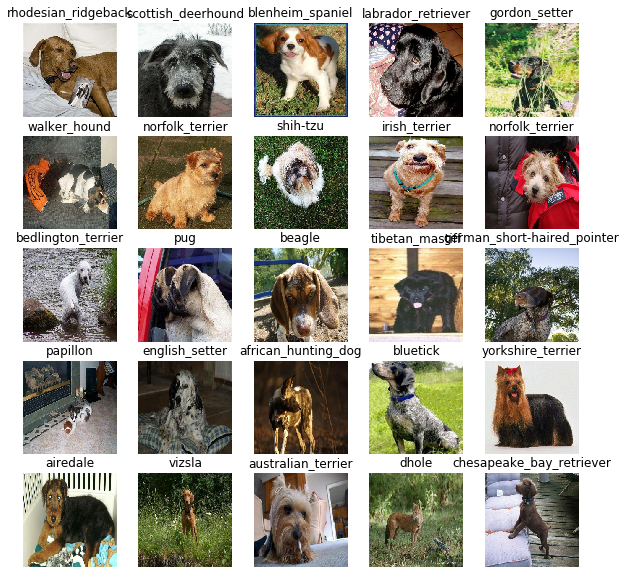

In [0]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

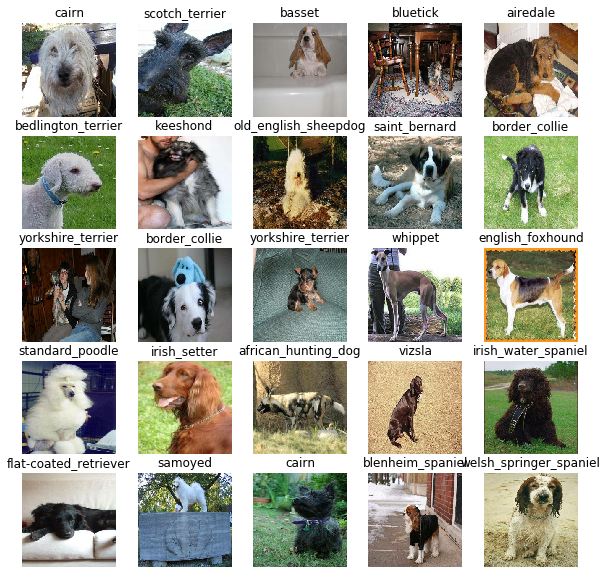

In [0]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things that we need to define:

* The input shape (shape of images, in the form of Tensors) of our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of our model from TensorFlow hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [0]:
# Setup input of our model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# Setup output of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup URL of our model
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've for our inputs, outputs and model ready to go. Let's put them together in a Keras deep learning model:
Knowing this, we need a function that:
* Takes the input and output shapes as well as the model, as parameters.
* Defines the layers in Keras, in a sequential fashion (do this, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells it the input shape that it'll be getting).
* Returns the model

In [0]:
# Creates a function that builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  """
  """
  print("Building model with: ", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL),  # Layer 1
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation="softmax") # Layer 2
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [0]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks
Callbacks are helper functions a model can use during training to do certain tasks, for example:
* Check or save progress,
* Stop training early if a model stops improving, 
* etc. 

### TensorBoard Callback
To setup a TensorBoard callback we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it our model's `fit()` function.
3. Visualize our model's training logs with the `%tensorboard` magic function (implement after training). 

In [0]:
# Load tensorboard notebook extension
%load_ext tensorboard

In [0]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a logs directory for storing tensorboard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        # Ensure the logs get tracked for every experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback
Early stopping helps prevent a model from overfitting by stopping its training when a certain evaluation metric stops improving.



In [0]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on a subset of data)

Our first model is going to train on 1000 images, to make sure everything is working.

We're going to create a function that trains the model:
* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it our training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [0]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10} 


In [0]:
# Builds a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version
  """
  # Create a new model
  model = create_model()

  # Create a new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it our callbacks
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])  
  # Return the fitted model
  return model

In [0]:
# Fit the model to the data
model = train_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Train for 25 steps, validate for 7 steps
Epoch 1/100
25/25 [==============================] - 490s 20s/step - loss: 4.5415 - accuracy: 0.1000 - val_loss: 3.3784 - val_accuracy: 0.2850
Epoch 2/100
25/25 [==============================] - 5s 198ms/step - loss: 1.5587 - accuracy: 0.7038 - val_loss: 2.1135 - val_accuracy: 0.4950
Epoch 3/100
25/25 [==============================] - 5s 197ms/step - loss: 0.5339 - accuracy: 0.9400 - val_loss: 1.6418 - val_accuracy: 0.6000
Epoch 4/100
25/25 [==============================] - 5s 197ms/step - loss: 0.2406 - accuracy: 0.9875 - val_loss: 1.4721 - val_accuracy: 0.6400
Epoch 5/100
25/25 [==============================] - 5s 203ms/step - loss: 0.1413 - accuracy: 1.0000 - val_loss: 1.3708 - val_accuracy: 0.6700
Epoch 6/100
25/25 [==============================] - 5s 199ms/step - loss: 0.0982 - accuracy: 0.9987 - val_loss: 1.3338 - val_accuracy: 0.6750
Epoch 7

### Checking the TensorBoard logs
The TensorBoard magic function (`%tensorboard`) will access the logs directory and visualize the contents.

In [0]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs

<IPython.core.display.Javascript object>

## Making predictions using a trained model


In [0]:
# Make predictions on the validation data (which was not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 196ms/step


array([[5.61180059e-04, 5.30864527e-05, 4.22792102e-04, ...,
        1.52626963e-04, 6.34152748e-05, 1.19187962e-02],
       [1.27902010e-03, 2.71601282e-04, 3.83092696e-03, ...,
        9.05152920e-05, 1.07078371e-03, 6.79020770e-04],
       [5.42550288e-06, 6.28300128e-04, 1.17302407e-04, ...,
        4.99934016e-04, 3.77942633e-05, 3.77042475e-03],
       ...,
       [3.80913775e-06, 2.66735096e-05, 5.40719475e-06, ...,
        1.85744484e-05, 1.11334984e-05, 2.67497544e-05],
       [1.20638439e-03, 1.47527782e-04, 1.14085515e-05, ...,
        1.33221074e-05, 1.13798860e-05, 4.27601067e-03],
       [4.39661817e-04, 1.71089159e-05, 3.67598113e-04, ...,
        3.96713178e-04, 1.40904347e-04, 2.58090186e-05]], dtype=float32)

In [0]:
# Notice that the predictions has the same shape as the validation labels and unique labels
predictions.shape, len(y_val), len(unique_breeds)

((200, 120), 200, 120)

In [0]:
# First prediction
index = 42
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

Max value (probability of prediction): 0.8406734466552734
Sum: 1.0
Max index: 113
Predicted label: walker_hound


Having this functionality is great but we need to do it at scale. 

It would be better if we could see the image alongside the probability.

**Note:** Prediction probabilities are also known as confidence levels.

In [0]:
# Turn the prediction probabilities into their respective labels
def get_pred_label(prediction_probabilities):
  """
  Turns an array of probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

Now, since our validation is still a batch dataset, we'll have to 'unbatchify' it to make predictions on the validation images and then compare those predictions to the validation (truth) labels. 

In [0]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [0]:
# Create a function to 'unbatch' a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separated arrays of images and labels.
  """
  images = []
  labels = []
  # Loop through the unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now that we have got the:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make a function to make these more visual.

We'll create a function that:
* Takes an array of predictions, an array of probabilities, an array of images and an integer.
* Covert the prediction probabilities to a predicted label.
* Plot the predicted label, predicted probability, the truth label and the target image to a single plot

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, truth and image for a sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Plot the image and remove the ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on whether the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change the plot title to be predicted label, prediction probability & truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                  np.max(pred_prob)*100,
                                  true_label),
            color=color)

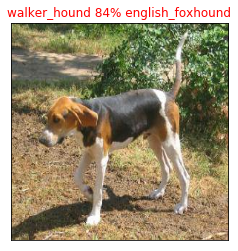

In [0]:
plot_pred(prediction_probabilities=predictions, 
          labels=val_labels, 
          images=val_images,
          n=42)

Now that we've got a model to visual the model's top prediction, let's create another to view it's top 10 predictions. 

This function needs to:
* Take an input of an array of prediction probailities, an array of truth labels and an integer.
* Find the prediction using `get_pred_label()`
* Find the top 10 prediction probability indexes, values and labels.
* Plot the top 10 prediction probability values and labels, colouring true labels green.

In [0]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 prediction confidences along with truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                               top_10_pred_values,
                               color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

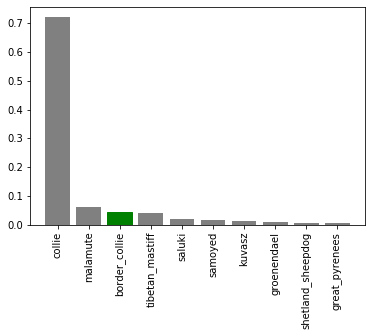

In [0]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now that we have another function to help visualize the predictions, let's combine these function across a few samples.

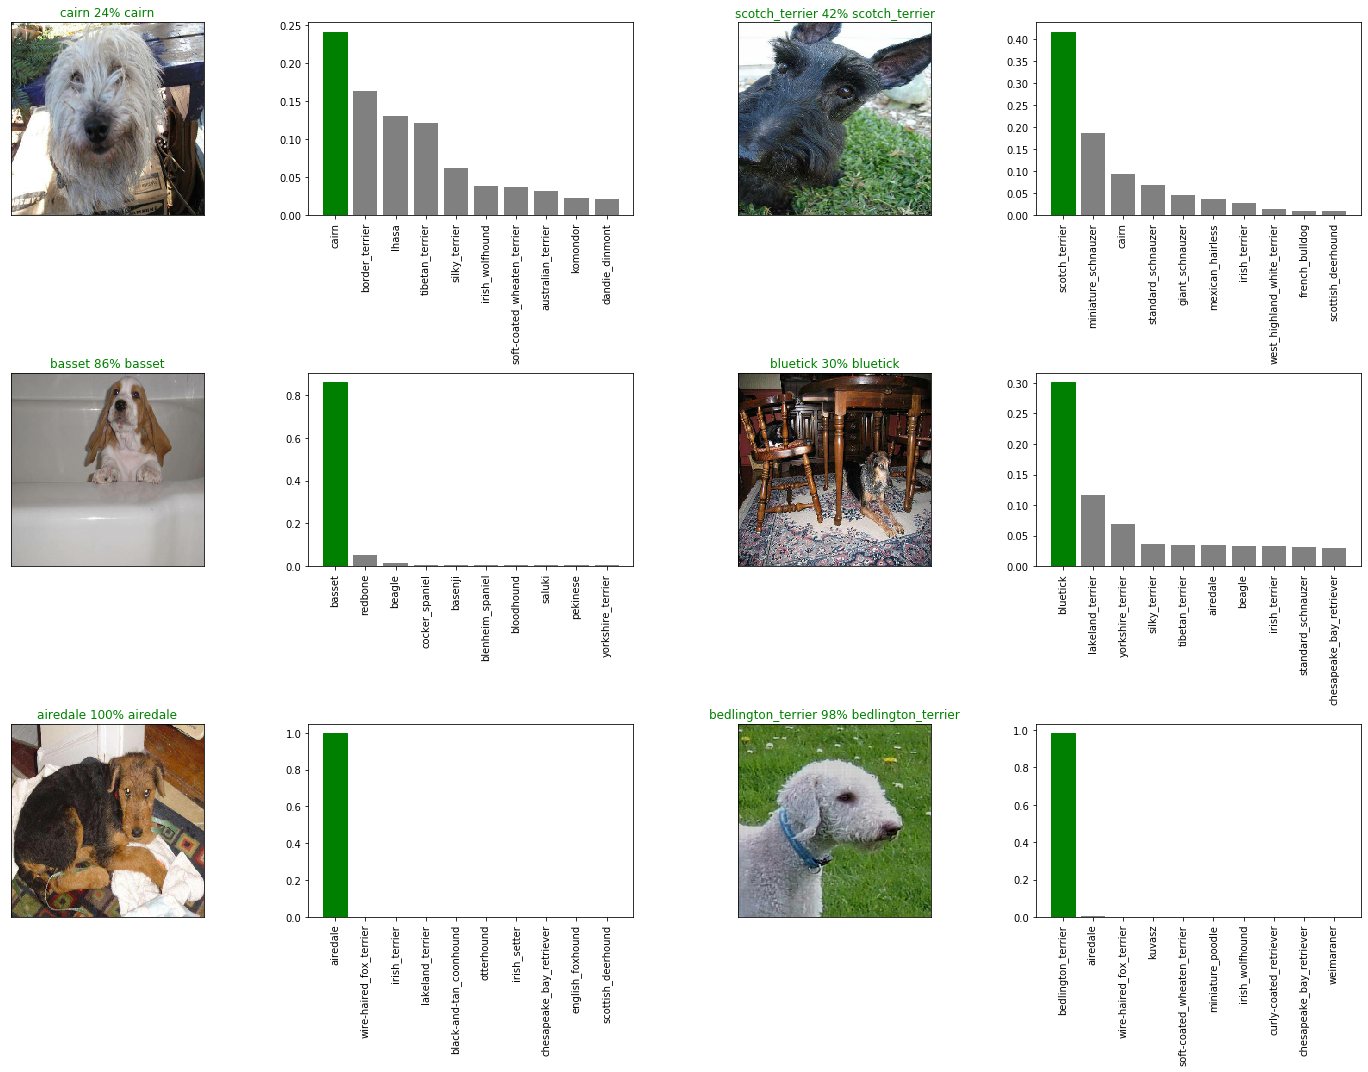

In [0]:
# View a few predictions and their values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and loading a trained model

In [0]:
# Create a function to save a trained model
def save_model(model, suffix=None):
  """
  Saves a model in the models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of a model
  print(f"Saving model to {model_path}")
  model.save(model_path)
  return model_path

In [0]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now that we've got functions to save and load trained models, let's check that they work.

In [0]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to drive/My Drive/Dog Vision/models/20200225-114102-1000-images-mobilenetv2-Adam.h5


'drive/My Drive/Dog Vision/models/20200225-114102-1000-images-mobilenetv2-Adam.h5'

In [0]:
# Load a trained model
loaded_1000_image_model = load_model('drive/My Drive/Dog Vision/models/20200225-114102-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Dog Vision/models/20200225-114102-1000-images-mobilenetv2-Adam.h5


In [0]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 147ms/step - loss: 1.2018 - accuracy: 0.7100


[1.2018449221338545, 0.71]

In [0]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 195ms/step - loss: 1.2018 - accuracy: 0.7100


[1.2018449221338545, 0.71]

## Training a model (on all of the data)



In [0]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [0]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [0]:
# Create a model for full data
full_model = create_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on full data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [0]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, 
                          full_model_early_stopping])

Train for 320 steps
Epoch 1/100
320/320 [==============================] - 5363s 17s/step - loss: 1.3346 - accuracy: 0.6682
Epoch 2/100
320/320 [==============================] - 54s 168ms/step - loss: 0.4034 - accuracy: 0.8791
Epoch 3/100
320/320 [==============================] - 54s 168ms/step - loss: 0.2375 - accuracy: 0.9354
Epoch 4/100
320/320 [==============================] - 54s 168ms/step - loss: 0.1557 - accuracy: 0.9625
Epoch 5/100
320/320 [==============================] - 54s 168ms/step - loss: 0.1062 - accuracy: 0.9775
Epoch 6/100
320/320 [==============================] - 53s 167ms/step - loss: 0.0767 - accuracy: 0.9875
Epoch 7/100
320/320 [==============================] - 54s 169ms/step - loss: 0.0591 - accuracy: 0.9919
Epoch 8/100
320/320 [==============================] - 53s 167ms/step - loss: 0.0472 - accuracy: 0.9937
Epoch 9/100
320/320 [==============================] - 54s 168ms/step - loss: 0.0366 - accuracy: 0.9965
Epoch 10/100
320/320 [======================

In [0]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to drive/My Drive/Dog Vision/models/20200225-134415-full-image-set-mobilenetv2-Adam.h5


'drive/My Drive/Dog Vision/models/20200225-134415-full-image-set-mobilenetv2-Adam.h5'

In [0]:
# Load in the full model
loaded_full_model = load_model('drive/My Drive/Dog Vision/models/20200225-134415-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Dog Vision/models/20200225-134415-full-image-set-mobilenetv2-Adam.h5


## Making predictions (on our test data)

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily, we've already created `create_data_batches()` that can take a list of filenames and convert them into batches.

To make predictions on the test data, we'll:
* Get the images into batches
* Convert the filenames into test data batches using `create_data_batches()`, using the `test_data` set to `True` (since the test data, doesn't have labels).
* Make a predictions array by passing the test batches to the `predict()` method called on our model.

In [0]:
# Load test image filenames
test_path = "drive/My Drive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/test/e96f1f52395b7e742fb5d83e1ac023b7.jpg',
 'drive/My Drive/Dog Vision/test/ed67035dba2de274aa95556038113c40.jpg',
 'drive/My Drive/Dog Vision/test/f1c41fe76fb9962343d34c58efb384cd.jpg',
 'drive/My Drive/Dog Vision/test/eaacea894e9bdda125ae215081a0d9fc.jpg',
 'drive/My Drive/Dog Vision/test/e9bcd763afd5e192fc047267c0b3cacd.jpg',
 'drive/My Drive/Dog Vision/test/eeb2c4ba7170968ce151916667c450a3.jpg',
 'drive/My Drive/Dog Vision/test/f1f42942df460f38181e12ebce695b5e.jpg',
 'drive/My Drive/Dog Vision/test/f13011a399f175d88c17d2bd1785625e.jpg',
 'drive/My Drive/Dog Vision/test/eadffa2af96b121d7e61dcd91ab11a39.jpg',
 'drive/My Drive/Dog Vision/test/f39a1f1692b67eb9c92a29f14a07d568.jpg']

In [0]:
# Create test data batches
test_data = create_data_batches(test_filenames, test_data=True)
test_data

Creating test data batches...


**Note:** Since there are 10,000+ test images, making predictions could take a while, even on a GPU. So beware running the cell below may take up to an hour.

In [0]:
# Make predictions on test data batches
test_predictions = loaded_full_model.predict(test_data,
                                     verbose=1)

 10/324 [..............................] - ETA: 1:48:49

KeyboardInterrupt: ignored

In [0]:
# Save predictions (numpy array) to csv file for later
# np.savetxt("drive/My Drive/Dog Vision/dog-vision-prediction-probabilites-array.csv", delimiter=",")

In [0]:
# EXTRA: Load predictions from file
test_predictions = np.loadtxt("drive/My Drive/Dog Vision/dog-vision-prediction-probabilites-array.csv", delimiter=",")

In [0]:
# Check first ten rows
test_predictions[:10]

array([[1.61196489e-09, 3.44086413e-12, 2.32834394e-11, ...,
        1.06917716e-13, 1.58530451e-08, 1.52161670e-06],
       [3.17894322e-10, 3.20088262e-14, 1.85374840e-10, ...,
        7.00588814e-08, 1.88822238e-08, 2.56980937e-10],
       [4.27301083e-09, 1.84139528e-13, 1.11784948e-09, ...,
        2.71949238e-12, 2.23927123e-06, 7.41860809e-11],
       ...,
       [4.47232779e-10, 4.28004029e-07, 4.11986996e-08, ...,
        4.65437893e-07, 8.21722967e-10, 8.86002116e-09],
       [3.50528079e-11, 1.94377336e-03, 1.44941642e-10, ...,
        1.56135718e-06, 6.13228721e-08, 7.32120961e-12],
       [1.23221771e-08, 3.08354520e-09, 1.87174110e-10, ...,
        8.16165635e-10, 9.98905063e-01, 6.73740752e-09]])

## Preparing a file to submit to Kaggle

Looking at the [Kaggle sample submission](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation), it looks like they want the models output probabilities each for label along with the image ID's.

To get the data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns using the unique_breeds list and the test_predictions list.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [0]:
# Create a Pandas DataFrame
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [0]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids
preds_df.head()

id  ... yorkshire_terrier
0  e96f1f52395b7e742fb5d83e1ac023b7  ...               NaN
1  ed67035dba2de274aa95556038113c40  ...               NaN
2  f1c41fe76fb9962343d34c58efb384cd  ...               NaN
3  eaacea894e9bdda125ae215081a0d9fc  ...               NaN
4  e9bcd763afd5e192fc047267c0b3cacd  ...               NaN

[5 rows x 121 columns]

In [0]:
# Append predictions to each column and row
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  e96f1f52395b7e742fb5d83e1ac023b7  ...       1.52162e-06
1  ed67035dba2de274aa95556038113c40  ...       2.56981e-10
2  f1c41fe76fb9962343d34c58efb384cd  ...       7.41861e-11
3  eaacea894e9bdda125ae215081a0d9fc  ...       6.13453e-11
4  e9bcd763afd5e192fc047267c0b3cacd  ...       1.31887e-06

[5 rows x 121 columns]

In [0]:
# Save our predictions csv for submission
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_0.csv",
                index=False)

## Making predictions on custom images

To make predictions on our custom images, we'll:

* Get the filepaths to our customer images.
* Turn the filepaths into data batches using `create_data_batch()` and set the `test_data` parameter to `True` (as there aren't any labels).
* Pass the customer image data batch to our model's `predict()` method.
* Covert the prediction output probabilities to prediction labels
* Compare the predicted labels to the customer images.

In [0]:
# Get the filepaths
custom_path = "drive/My Drive/Dog Vision/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [0]:
custom_image_paths

['drive/My Drive/Dog Vision/my-dog-photos/dog-photo-2.jpeg',
 'drive/My Drive/Dog Vision/my-dog-photos/dog-photo-1.jpeg',
 'drive/My Drive/Dog Vision/my-dog-photos/dog-photo-6.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/dog-photo-3.jpeg',
 'drive/My Drive/Dog Vision/my-dog-photos/dog-photo-4.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/dog-photo-5.jpg']

In [0]:
# Turn custom images into batch dataset
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [0]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)
custom_preds.shape

(6, 120)

In [0]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['lakeland_terrier',
 'golden_retriever',
 'rhodesian_ridgeback',
 'labrador_retriever',
 'beagle',
 'pekinese']

In [0]:
# Get custom images
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

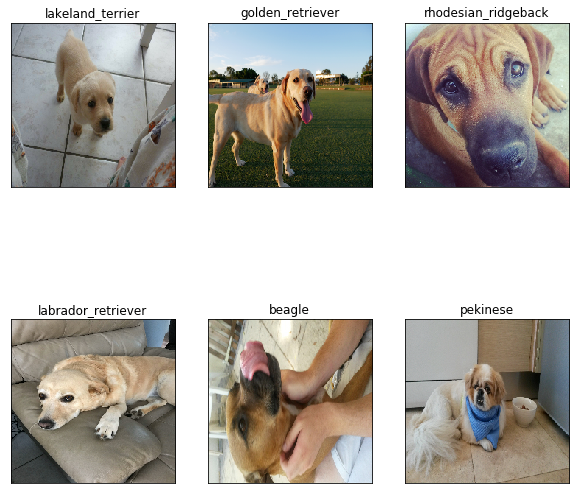

In [0]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(2, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)